<a href="https://colab.research.google.com/github/sfnesbit/Wildfire-Risk-Assessment/blob/main/Fire_Risk_Assessment_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#f56342'>Convolutional Neural Network to Determine Wildfire Risk</font>

Sean Nesbit

## Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd drive/MyDrive/Thesis/

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1s-sCgftbQNqDlvVEIP5E4gojbWb0lU24/Thesis


In [ ]:
import os
import gc
import sys
import time
import json
import math
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

### Color-Blind friendly palette

In [ ]:
color_red = '#D55E00'
color_pink = '#CC79A7'
color_blue =  '#0072B2'
color_black = '#000000'
color_yellow = '#F0E442'
color_orange = '#E69F00'
color_sky_blue = '#56B4E9'
color_bluish_green = '#009E73'

In [ ]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

            ImageDataGenerator:  1.0 KiB
                            L2:  1.0 KiB
                           _i4:  576.0 B
                           _ii:  548.0 B
                           _i2:  548.0 B
                            _i:  249.0 B
                           _i3:  249.0 B
                           _oh:  248.0 B
                           Out:  248.0 B
                          _iii:  156.0 B


---

## Retrieve Training Data

#### Load images into class arrays

In [ ]:
product_names = ['LST_Day_1km', 'Fpar', 'Lai', 'Gpp', 'ET', 'LE', 'PET', 'PLE', 'EVI', 'pr_wtr', 'elevation', 'precipitation', '1yr', '5yr', '10yr']
product_names.extend([f'LC_Type1_{num}' for num in range(17)])
print(product_names)

['LST_Day_1km', 'Fpar', 'Lai', 'Gpp', 'ET', 'LE', 'PET', 'PLE', 'EVI', 'pr_wtr', 'elevation', 'precipitation', '1yr', '5yr', '10yr', 'LC_Type1_0', 'LC_Type1_1', 'LC_Type1_2', 'LC_Type1_3', 'LC_Type1_4', 'LC_Type1_5', 'LC_Type1_6', 'LC_Type1_7', 'LC_Type1_8', 'LC_Type1_9', 'LC_Type1_10', 'LC_Type1_11', 'LC_Type1_12', 'LC_Type1_13', 'LC_Type1_14', 'LC_Type1_15', 'LC_Type1_16']


In [ ]:
burned_imgs = np.load("climate/burned3100.npy").astype('uint8')
unburned_imgs = np.load("climate/unburned13000.npy").astype('uint8')

Expand land cover type into 17 layers

In [ ]:
#burned_imgs = binarize_LC_Type(burned_imgs)
#unburned_imgs = binarize_LC_Type(unburned_imgs)

(3100, 64, 64, 32)
(13000, 64, 64, 32)


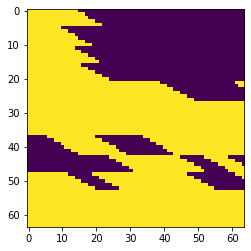

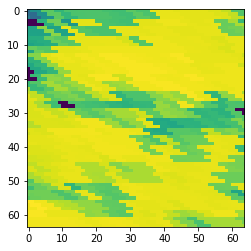

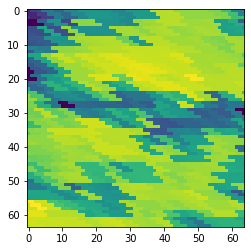

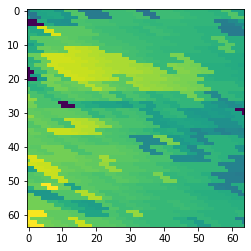

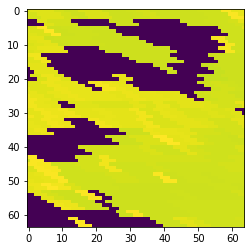

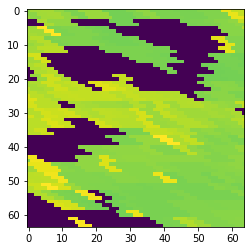

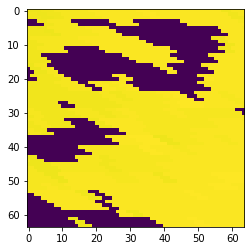

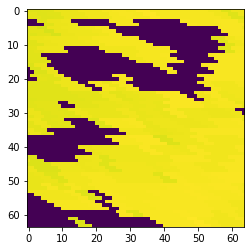

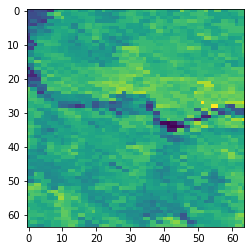

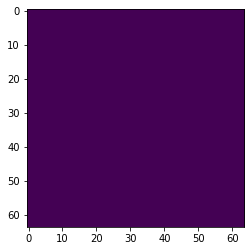

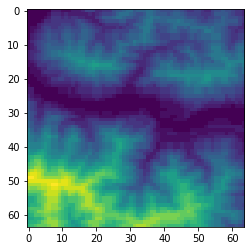

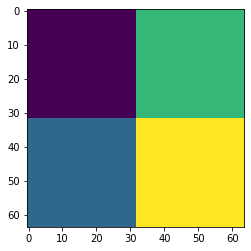

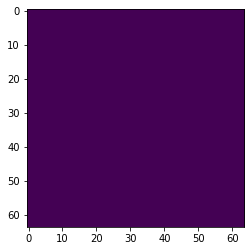

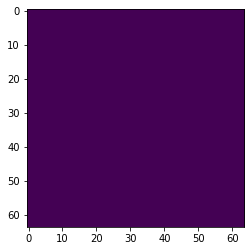

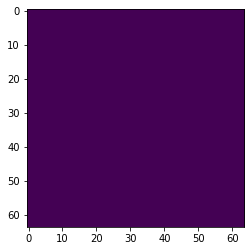

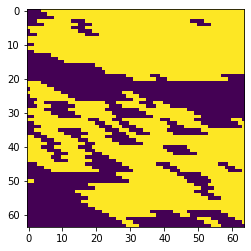

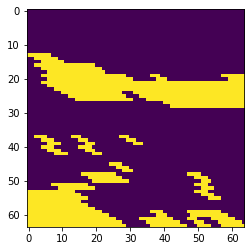

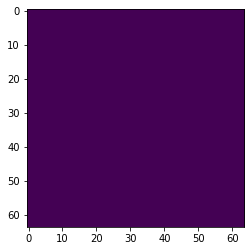

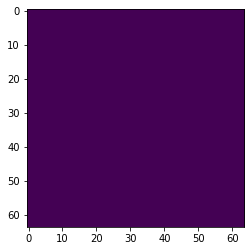

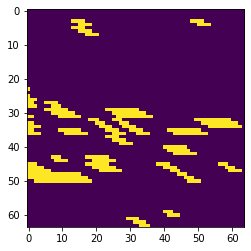

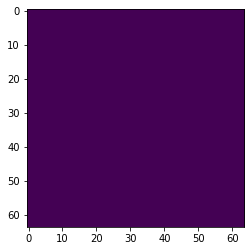

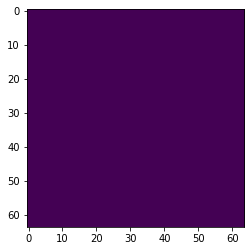

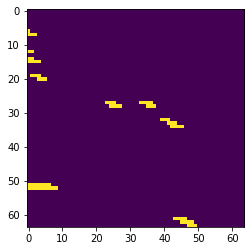

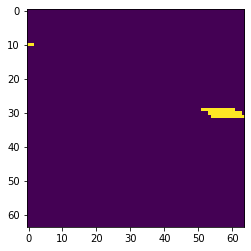

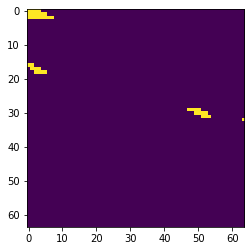

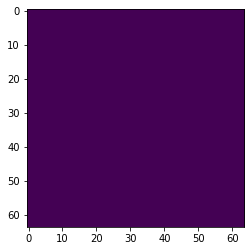

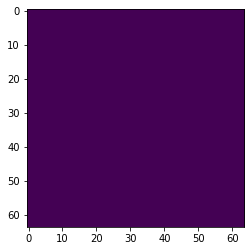

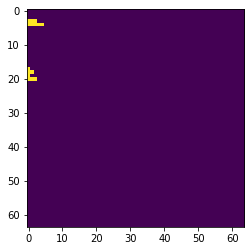

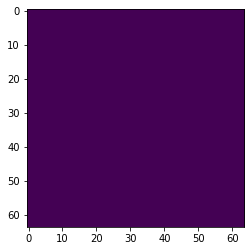

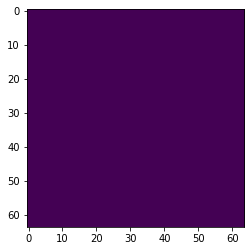

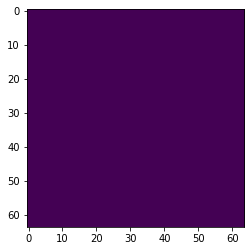

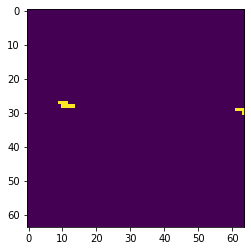

In [ ]:
print(burned_imgs.shape)
print(unburned_imgs.shape)
for i in range(burned_imgs.shape[3]):
  plt.imshow(burned_imgs[100,:,:,i])
  plt.show()

#### Create X and y arrays with associated labels

In [ ]:
# define labels
burned_label = 1
unburned_label = 0

# Train/Test split
testing_pos = 100
testing_neg = 3000
training_pos = 100
training_neg = 10000

X = np.append(burned_imgs[:training_pos], unburned_imgs[:training_neg], 0)
y = np.concatenate([training_pos*[burned_label], training_neg*[unburned_label]])

X_test = np.append(burned_imgs[training_pos:(training_pos+testing_pos)], unburned_imgs[training_neg:(training_neg+testing_neg)], 0)
y_test = np.concatenate([testing_pos*[burned_label], testing_neg*[unburned_label]])
X_test5050 = np.append(burned_imgs[training_pos:(training_pos+testing_pos)], unburned_imgs[training_neg:(training_neg+testing_pos)], 0)
y_test5050 = np.concatenate([testing_pos*[burned_label], testing_pos*[unburned_label]])

del burned_imgs
del unburned_imgs

In [ ]:
# define labels
burned_label = 1
unburned_label = 0

# Train/Test split
training_pos = 3000
training_neg = 3000
testing_pos = 100
testing_neg = 10000

X = np.append(burned_imgs[:training_pos], unburned_imgs[:training_neg], 0)
y = np.concatenate([training_pos*[burned_label], training_neg*[unburned_label]])

X_test = np.append(burned_imgs[training_pos:(training_pos+testing_pos)], unburned_imgs[training_neg:(training_neg+testing_neg)], 0)
y_test = np.concatenate([testing_pos*[burned_label], testing_neg*[unburned_label]])
X_test5050 = np.append(burned_imgs[training_pos:(training_pos+testing_pos)], unburned_imgs[training_neg:(training_neg+testing_pos)], 0)
y_test5050 = np.concatenate([testing_pos*[burned_label], testing_pos*[unburned_label]])

del burned_imgs
del unburned_imgs

In [ ]:
# Augment training set (random rotations * flips = len*4)
np.random.seed(599)
X = np.concatenate((X,
      np.rot90(X, k=1, axes=(1, 2)),
      np.rot90(X, k=2, axes=(1, 2)),
      np.rot90(X, k=3, axes=(1, 2))))
X = np.concatenate((X, np.flip(X, axis=-2)))
y = np.tile(y, 8)

X, y = shuffle(X, y)
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
print(f"Train:\n\tX: {X.shape}\n\ty: {y.shape}\n\tburned_imgs: {sum(y)}")
print(f"Test:\n\tX_test: {X_test.shape}\n\ty_test: {y_test.shape}\n\tburned_imgs: {sum(y_test)}")
print(f"Test5050:\n\tX_test: {X_test5050.shape}\n\ty_test: {y_test5050.shape}\n\tburned_imgs: {sum(y_test)}")

Train:
	X: (80800, 64, 64, 32)
	y: (80800,)
	burned_imgs: 800
Test:
	X_test: (3100, 64, 64, 32)
	y_test: (3100,)
	burned_imgs: 100
Test5050:
	X_test: (200, 64, 64, 32)
	y_test: (200,)
	burned_imgs: 100


### Display sample images

Shape:  (64, 64, 32)


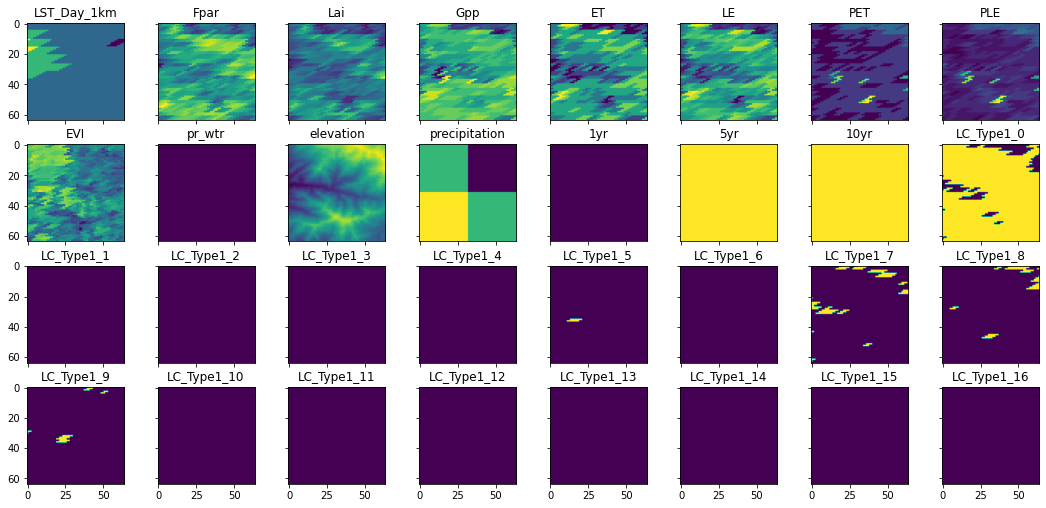

In [ ]:
# take a burned example to display
burned_ex = X[np.where(y == burned_label)[0]][11]
nrow = 4
ncol = 8

# Output shape of the image
print("Shape: ", burned_ex.shape)

# set up subplot view
fig, axs = plt.subplots(nrow, ncol, 
    gridspec_kw=dict(
      wspace=0.2, hspace=0.25,
      top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1), 
      left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)
    ),
    figsize=(ncol *2, nrow *2), sharey='row', sharex='col')

axs = axs.flatten()
imgs = [(burned_ex[:,:,i],product_names[i]) for i in range(burned_ex.shape[2])]

for img_tuple, ax in zip(imgs, axs):
    if img_tuple[1] in product_names[12:]:
      ax.imshow(img_tuple[0], vmin=0, vmax=1)
    else:
      ax.imshow(img_tuple[0])
    ax.set_title(img_tuple[1])
plt.show()

---

## Build Model

### Architecture

In [ ]:
def gen_model(input_shape=(64,64,32)):
  model = models.Sequential()
#, kernel_regularizer=L2(0.01)
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Dropout(0.15))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Dropout(0.15))

  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(256, activation='relu', kernel_regularizer=L2(0.01)))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=L2(0.01)))
  model.add(layers.Dense(2, activation='softmax'))

  model.summary()
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Fit

In [ ]:
model = gen_model()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'Models/CNN/CNN_Checkpoint/CNN_imbalanced.hdf5',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_only_best=True
)

reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.15,
    patience=4, 
    min_lr=0,
    verbose=1
)

history = model.fit(
    x=X, 
    y=y,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    validation_batch_size=128,
    callbacks=[checkpoint_callback, reduceLR_callback])
#model.load_weights('Models/CNN/CNN_Checkpoint/')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       7

### Save Model

In [ ]:
model.save('Models/CNN/CNN_imbalanced.h5')
np.save('Models/CNN/CNN_imbalanced_history.npy',history.history)

### Load Model

In [ ]:
model = tf.keras.models.load_model('Models/CNN/CNN_imbalanced.h5')
history=np.load('Models/CNN/CNN_imbalanced_history.npy',allow_pickle='TRUE').item()

---

## Results

In [ ]:
import warnings
warnings.filterwarnings('ignore') # silence Scikit-learn

def tune_recall_threshold(y_pred, y_test, recall_min=0.90):
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  precision = precision[::-1]
  recall = recall[::-1]
  thresholds = thresholds[::-1]
  idx = np.argmax(np.array(recall) >= recall_min)
  return thresholds[idx]

def tune_precision_threshold(y_pred, y_test, precision_min=0.90):
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  precision = precision[::-1]
  recall = recall[::-1]
  thresholds = thresholds[::-1]
  idx = np.argmax(np.array(precision) >= precision_min)
  return thresholds[idx]

def highest_f1_threshold(y_pred, y_test):
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  thr = -1
  max_f1 = -1
  for threshold in thresholds:
     report = classification_report(y_test, np.where(y_pred > threshold, 1, 0), target_names=["unburned (0)", "burned (1)"], output_dict=True)
     f1 = report['burned (1)']['f1-score']
     if f1 > max_f1:
       max_f1 = f1
       thr = threshold
  return thr

def scores(y_test, y_pred, threshold=0.5):
  y_pred_bool = np.where(y_pred > threshold, 1, 0)
  accuracy = accuracy_score(y_test, y_pred_bool)
  f1 = f1_score(y_test, y_pred_bool)
  precision = precision_score(y_test, y_pred_bool)
  recall = recall_score(y_test, y_pred_bool)
  return accuracy, f1, precision, recall

def print_performance_metrics(accuracy, f1, precision, recall, threshold=0.5, print_threshold=False):
  if print_threshold:
    print(f"\tThreshold: {threshold:0.3f}")
  print(f"\tAccuracy: {accuracy:0.3f}")
  print(f"\tF1-Score: {f1:0.3f}")
  print(f"\tPrecision: {precision:0.3f}")
  print(f"\tRecall: {recall:0.3f}")

### Accuracy & Loss

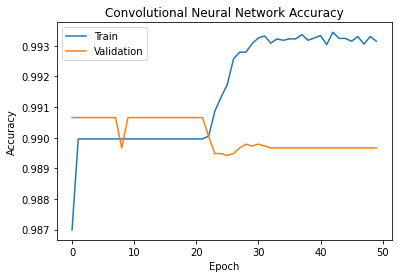

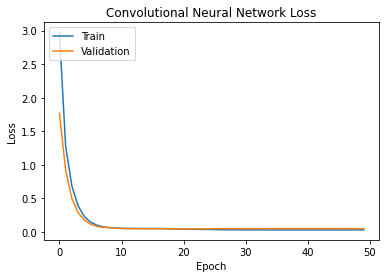

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Convolutional Neural Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Convolutional Neural Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### ROC Curve

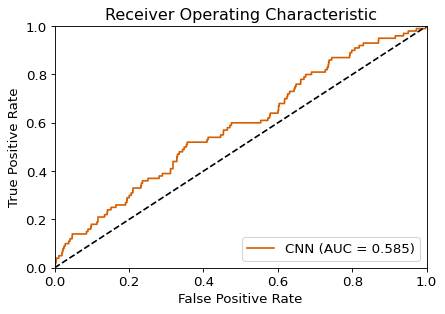

In [ ]:
y_pred = model.predict(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6, 4), dpi=80)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'CNN (AUC = %0.3f)' % roc_auc, color=color_red)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color=color_black)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Precision-Recall Curve

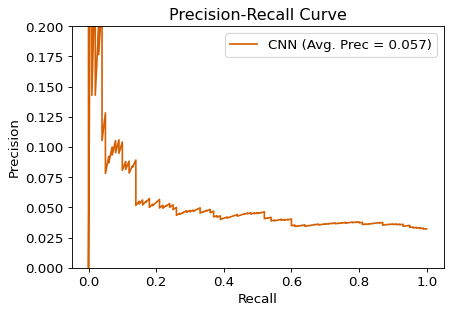

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6, 4), dpi=80)
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, label = 'CNN (Avg. Prec = %0.3f)' % ap, color=color_red)
plt.legend(loc = 'top right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0,.2)
plt.show()

---

### Performance Metrics

In [ ]:
y_pred = model.predict(X_test)[:,1]
CNN_acc, CNN_f1, CNN_prec, CNN_rec = scores(y_test, y_pred, threshold=0.5)
print_performance_metrics(CNN_acc, CNN_f1, CNN_prec, CNN_rec, threshold=0.5)

	Accuracy: 0.965
	F1-Score: 0.036
	Precision: 0.182
	Recall: 0.020


### Tuning Burned Recall to 0.90

In [ ]:
thr = tune_recall_threshold(y_pred, y_test, recall_min=0.90)
acc, f1, prec, rec = scores(y_test, y_pred, threshold=thr)
print("Convolutional Neural Network - Recall @ 0.900")
print_performance_metrics(acc, f1, prec, rec, threshold=thr, print_threshold=True)

Convolutional Neural Network - Recall @ 0.900
	Threshold: 0.000
	Accuracy: 0.224
	F1-Score: 0.070
	Precision: 0.036
	Recall: 0.900


## Comparison Models

### Data Modification

In [ ]:
#X.shape == (64,64,11)
X_comp = np.array([x.reshape(-1,x.shape[-1]).mean(0) for x in X])
X_comp_test = np.array([x.reshape(-1,x.shape[-1]).mean(0) for x in X_test])
X_comp_test5050 = np.array([x.reshape(-1,x.shape[-1]).mean(0) for x in X_test5050])
num_classes = 2
num_features = X_comp.shape[1]
steps = (len(X_comp)/32)*8
print(steps)
print(X_comp.shape)
print(X_comp_test.shape)
print(y.shape)

1500.0
(6000, 32)
(10100, 32)
(6000,)


### Build Comparison Architectures

In [ ]:
num_classes=2
num_features=32

In [ ]:
ANN32.summary()
ANN64.summary()
ANN128.summary()
ANN256.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,122
Trainable params: 1,122
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,242
Trainable 

#### Logistic Regression

In [ ]:
LR = models.Sequential()
LR.add(layers.Dense(num_classes, activation = 'softmax',input_dim = num_features))
LR.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/Comparison/LR_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.15,
    patience=4, 
    min_lr=0,
    verbose=1
)

history_LR = LR.fit(X_comp,  y, epochs=50, validation_split=0.2, steps_per_epoch=steps, callbacks=[model_checkpoint_callback, reduceLR_callback])
LR.load_weights('Models/Comparison/LR_Checkpoint/')

Epoch 1/50
1469/1500 [============================>.] - ETA: 0s - loss: 3.1898 - accuracy: 0.5873
Epoch 1: val_accuracy improved from -inf to 0.09833, saving model to Models/Comparison/LR_Checkpoint/
INFO:tensorflow:Assets written to: Models/Comparison/LR_Checkpoint/assets
1500/1500 [==============================] - 7s 3ms/step - loss: 3.1485 - accuracy: 0.5882 - val_loss: 4.3598 - val_accuracy: 0.0983 - lr: 0.0010
Epoch 2/50
1470/1500 [============================>.] - ETA: 0s - loss: 0.8215 - accuracy: 0.6706
Epoch 2: val_accuracy improved from 0.09833 to 0.82167, saving model to Models/Comparison/LR_Checkpoint/
INFO:tensorflow:Assets written to: Models/Comparison/LR_Checkpoint/assets
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8203 - accuracy: 0.6722 - val_loss: 0.4009 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 3/50
1487/1500 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.7102
Epoch 3: val_accuracy improved from 0.82167 to 0.82583, sav

#### Aritificial Neural Network

In [ ]:
# FCNN - 1 hidden layer - 32 nodes
num_features = 32
ANN32 = models.Sequential()
ANN32.add(layers.Input(shape=(num_features,)))
ANN32.add(layers.Dense(32, activation='relu'))
ANN32.add(layers.Dense(num_classes, activation='softmax'))
ANN32_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/Comparison/ANN32_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# FCNN - 1 hidden layer - 64 nodes
ANN64 = models.Sequential()
ANN64.add(layers.Input(shape=(num_features,)))
ANN64.add(layers.Dense(64, activation='relu'))
ANN64.add(layers.Dense(num_classes, activation='softmax'))
ANN64_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/Comparison/ANN64_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# FCNN - 1 hidden layer - 128 nodes
ANN128 = models.Sequential()
ANN128.add(layers.Input(shape=(num_features,)))
ANN128.add(layers.Dense(128, activation='relu'))
ANN128.add(layers.Dense(num_classes, activation='softmax'))
ANN128_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/Comparison/ANN128_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# FCNN - 1 hidden layer - 256 nodes
ANN256 = models.Sequential()
ANN256.add(layers.Input(shape=(num_features,)))
ANN256.add(layers.Dense(256, activation='relu'))
ANN256.add(layers.Dense(num_classes, activation='softmax'))
ANN256_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/Comparison/ANN256_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
ANN32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ANN64.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ANN128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ANN256.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print("/\\"*10 + " ANN 32 " + "/\\"*20)
history_ANN32 = ANN32.fit(X_comp, y, epochs=50, validation_split=0.2, steps_per_epoch=steps, callbacks=[ANN32_callback, reduceLR_callback])
ANN32.load_weights('Models/Comparison/ANN32_Checkpoint/')

print("\/\\"*10 + " ANN 64 " + "/\\"*20)
history_ANN64 = ANN64.fit(X_comp, y, epochs=50, validation_split=0.2, steps_per_epoch=steps, callbacks=[ANN64_callback, reduceLR_callback])
ANN64.load_weights('Models/Comparison/ANN64_Checkpoint/')

print("/\\"*10 + " ANN 128 " + "/\\"*20)
history_ANN128 = ANN128.fit(X_comp, y, epochs=50, validation_split=0.2, steps_per_epoch=steps, callbacks=[ANN128_callback, reduceLR_callback])
ANN128.load_weights('Models/Comparison/ANN128_Checkpoint/')

print("/\\"*10 + " ANN 256 " + "/\\"*20)
history_ANN256 = ANN256.fit(X_comp, y, epochs=50, validation_split=0.2, steps_per_epoch=steps, callbacks=[ANN256_callback, reduceLR_callback])
ANN256.load_weights('Models/Comparison/ANN256_Checkpoint/')


/\/\/\/\/\/\/\/\/\/\ ANN 32 /\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
Epoch 1/50
1487/1500 [============================>.] - ETA: 0s - loss: 1.1981 - accuracy: 0.6547
Epoch 1: val_accuracy improved from -inf to 0.56750, saving model to Models/Comparison/ANN32_Checkpoint/
INFO:tensorflow:Assets written to: Models/Comparison/ANN32_Checkpoint/assets
1500/1500 [==============================] - 4s 3ms/step - loss: 1.1947 - accuracy: 0.6550 - val_loss: 1.3509 - val_accuracy: 0.5675 - lr: 0.0010
Epoch 2/50
1471/1500 [============================>.] - ETA: 0s - loss: 0.9079 - accuracy: 0.6975
Epoch 2: val_accuracy did not improve from 0.56750
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9020 - accuracy: 0.6983 - val_loss: 2.3303 - val_accuracy: 0.1983 - lr: 0.0010
Epoch 3/50
1486/1500 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.7137
Epoch 3: val_accuracy improved from 0.56750 to 0.98500, saving model to Models/Comparison/ANN32_Checkpoint/
INFO

#### Save Models

In [ ]:
LR.save('Models/Comparison/LR_v2.h5')
ANN32.save('Models/Comparison/ANN32_v2.h5')
ANN64.save('Models/Comparison/ANN64_v2.h5')
ANN128.save('Models/Comparison/ANN128_v2.h5')
ANN256.save('Models/Comparison/ANN256_v2.h5')

np.save('Models/Comparison/LR_v2_history.npy',history_LR.history)
np.save('Models/Comparison/ANN32_v2_history.npy',history_ANN32.history)
np.save('Models/Comparison/ANN64_v2_history.npy',history_ANN64.history)
np.save('Models/Comparison/ANN128_v2_history.npy',history_ANN128.history)
np.save('Models/Comparison/ANN256_v2_history.npy',history_ANN256.history)

#### Load Models

In [ ]:
LR = tf.keras.models.load_model('Models/Comparison/LR_v2.h5')
ANN32 = tf.keras.models.load_model('Models/Comparison/ANN32_v2.h5')
ANN64 = tf.keras.models.load_model('Models/Comparison/ANN64_v2.h5')
ANN128 = tf.keras.models.load_model('Models/Comparison/ANN128_v2.h5')
ANN256 = tf.keras.models.load_model('Models/Comparison/ANN256_v2.h5')

history_LR=np.load('Models/Comparison/LR_v2_history.npy',allow_pickle='TRUE').item()
history_ANN32=np.load('Models/Comparison/ANN32_v2_history.npy',allow_pickle='TRUE').item()
history_ANN64=np.load('Models/Comparison/ANN64_v2_history.npy',allow_pickle='TRUE').item()
history_ANN128=np.load('Models/Comparison/ANN128_v2_history.npy',allow_pickle='TRUE').item()
history_ANN256=np.load('Models/Comparison/ANN256_v2_history.npy',allow_pickle='TRUE').item()

### Evaluation

In [ ]:
def print_latex(name, acc, f1, prec, rec):
  print(f'{name} & {acc:0.3f} & {f1:0.3f} & {prec:0.3f} & {rec:0.3f} \\\\[10pt]')

In [ ]:
y_pred_LR = LR.predict(X_comp_test)[:,1]
thr_LR_recall = tune_recall_threshold(y_pred_LR, y_test, recall_min=0.90)

y_pred_ANN32 = ANN32.predict(X_comp_test)[:,1]
thr_ANN32_recall = tune_recall_threshold(y_pred_ANN32, y_test, recall_min=0.90)

y_pred_ANN64 = ANN64.predict(X_comp_test)[:,1]
thr_ANN64_recall = tune_recall_threshold(y_pred_ANN64, y_test, recall_min=0.90)

y_pred_ANN128 = ANN128.predict(X_comp_test)[:,1]
thr_ANN128_recall = tune_recall_threshold(y_pred_ANN128, y_test, recall_min=0.90)

y_pred_ANN256 = ANN256.predict(X_comp_test)[:,1]
thr_ANN256_recall = tune_recall_threshold(y_pred_ANN256, y_test, recall_min=0.90)

y_pred_CNN = model.predict(X_test)[:,1]
thr_CNN_recall = tune_recall_threshold(y_pred_CNN, y_test, recall_min=0.90)


#### Base Model Comparisons

In [ ]:
model_names = ['LR', 'ANN32', 'ANN64', 'ANN128', 'ANN256', 'CNN']

LR_acc, LR_f1, LR_prec, LR_rec = scores(y_test, y_pred_LR, threshold=0.5)
ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec = scores(y_test, y_pred_ANN32, threshold=0.5)
ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec = scores(y_test, y_pred_ANN64, threshold=0.5)
ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec = scores(y_test, y_pred_ANN128, threshold=0.5)
ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec = scores(y_test, y_pred_ANN256, threshold=0.5)
CNN_acc, CNN_f1, CNN_prec, CNN_rec = scores(y_test, y_pred_CNN, threshold=0.5)


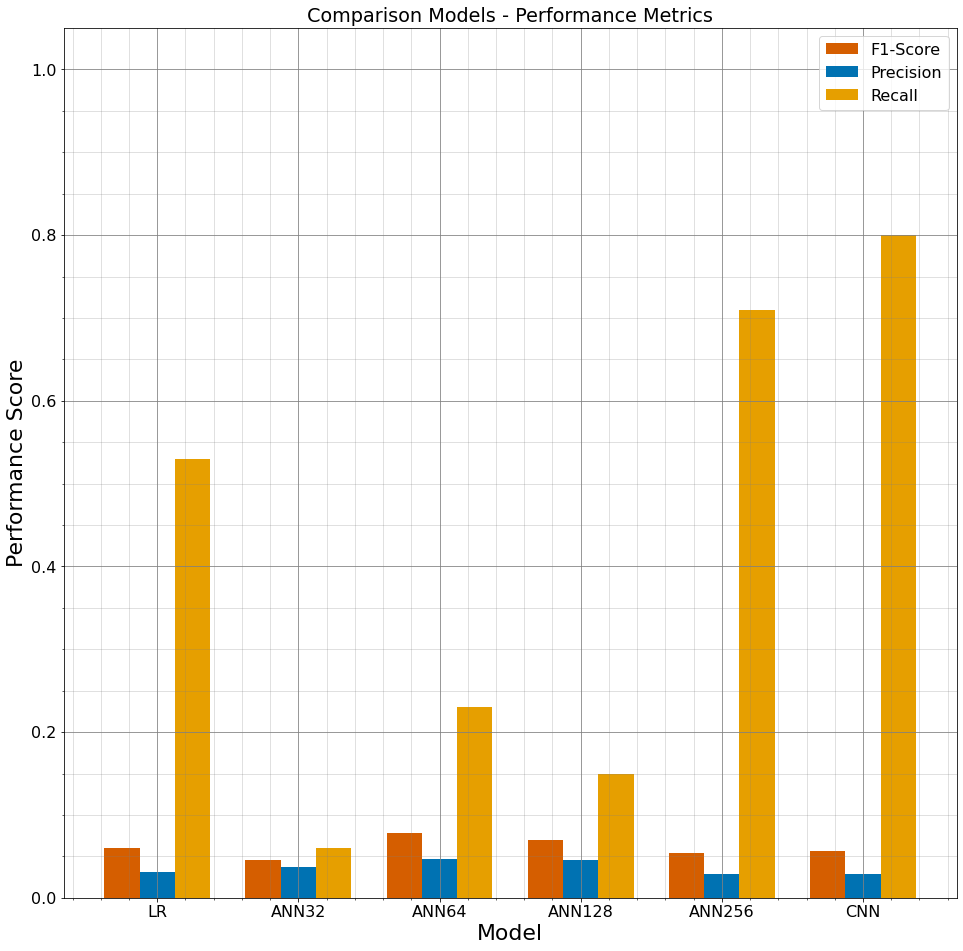

In [ ]:
accuracies = [LR_acc, ANN32_acc, ANN64_acc, ANN128_acc, ANN256_acc, CNN_acc]
f1s = [LR_f1, ANN32_f1, ANN64_f1, ANN128_f1, ANN256_f1, CNN_f1]
precisions = [LR_prec, ANN32_prec, ANN64_prec, ANN128_prec, ANN256_prec, CNN_prec]
recalls = [LR_rec, ANN32_rec, ANN64_rec, ANN128_rec, ANN256_rec, CNN_rec]

plt.rcParams["figure.figsize"] = (16,16)
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

#plt.bar(br1, accuracies, width=barWidth, label='Accuracy', color=color_p)
plt.rcParams.update({'font.size': 16})
plt.bar(br2, f1s, width=barWidth, label='F1-Score', color=color_red)
plt.bar(br3, precisions, width=barWidth, label='Precision', color=color_blue)
plt.bar(br4, recalls, width=barWidth, label='Recall', color=color_orange)
plt.ylim(0,1.05)

# Adding Xticks
plt.title("Comparison Models - Performance Metrics")
plt.xlabel('Model', fontsize = 22)
plt.ylabel('Performance Score', fontsize = 22)
plt.xticks([r + 2*barWidth for r in range(len(model_names))], model_names)
plt.minorticks_on()
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='-', alpha=0.3)
plt.legend()
plt.show()


In [ ]:
print("========== LR ==========")
print_performance_metrics(LR_acc, LR_f1, LR_prec, LR_rec)
print("========== ANN32 ==========")
print_performance_metrics(ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec)
print("========== ANN64 ==========")
print_performance_metrics(ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec)
print("========== ANN128 ==========")
print_performance_metrics(ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec)
print("========== ANN256 ==========")
print_performance_metrics(ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec)
print("========== CNN ==========")
print_performance_metrics(CNN_acc, CNN_f1, CNN_prec, CNN_rec)


========== LR ==========
	Accuracy: 0.835
	F1-Score: 0.060
	Precision: 0.032
	Recall: 0.530
========== ANN32 ==========
	Accuracy: 0.975
	F1-Score: 0.046
	Precision: 0.037
	Recall: 0.060
========== ANN64 ==========
	Accuracy: 0.946
	F1-Score: 0.078
	Precision: 0.047
	Recall: 0.230
========== ANN128 ==========
	Accuracy: 0.960
	F1-Score: 0.069
	Precision: 0.045
	Recall: 0.150
========== ANN256 ==========
	Accuracy: 0.756
	F1-Score: 0.054
	Precision: 0.028
	Recall: 0.710
========== CNN ==========
	Accuracy: 0.734
	F1-Score: 0.056
	Precision: 0.029
	Recall: 0.800


In [ ]:
print_latex("Logistic Regression", LR_acc, LR_f1, LR_prec, LR_rec)
print_latex("Artificial Neural Network - 32 Neurons", ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec)
print_latex("Artificial Neural Network - 64 Neurons", ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec)
print_latex("Artificial Neural Network - 128 Neurons", ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec)
print_latex("Artificial Neural Network - 256 Neurons", ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec)
print_latex("Convolutional Neural Network", CNN_acc, CNN_f1, CNN_prec, CNN_rec)

Logistic Regression & 0.835 & 0.060 & 0.032 & 0.530 \\[10pt]
Artificial Neural Network - 32 Neurons & 0.975 & 0.046 & 0.037 & 0.060 \\[10pt]
Artificial Neural Network - 64 Neurons & 0.946 & 0.078 & 0.047 & 0.230 \\[10pt]
Artificial Neural Network - 128 Neurons & 0.960 & 0.069 & 0.045 & 0.150 \\[10pt]
Artificial Neural Network - 256 Neurons & 0.756 & 0.054 & 0.028 & 0.710 \\[10pt]
Convolutional Neural Network & 0.734 & 0.056 & 0.029 & 0.800 \\[10pt]


#### Tune Burned Recall to 0.90

In [ ]:
model_names = ['LR', 'ANN32', 'ANN64', 'ANN128', 'ANN256', 'CNN']

LR_acc, LR_f1, LR_prec, LR_rec = scores(y_test, y_pred_LR, threshold=thr_LR_recall)
ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec = scores(y_test, y_pred_ANN32, threshold=thr_ANN32_recall)
ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec = scores(y_test, y_pred_ANN64, threshold=thr_ANN64_recall)
ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec = scores(y_test, y_pred_ANN128, threshold=thr_ANN128_recall)
ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec = scores(y_test, y_pred_ANN256, threshold=thr_ANN256_recall)
CNN_acc, CNN_f1, CNN_prec, CNN_rec = scores(y_test, y_pred_CNN, threshold=thr_CNN_recall)


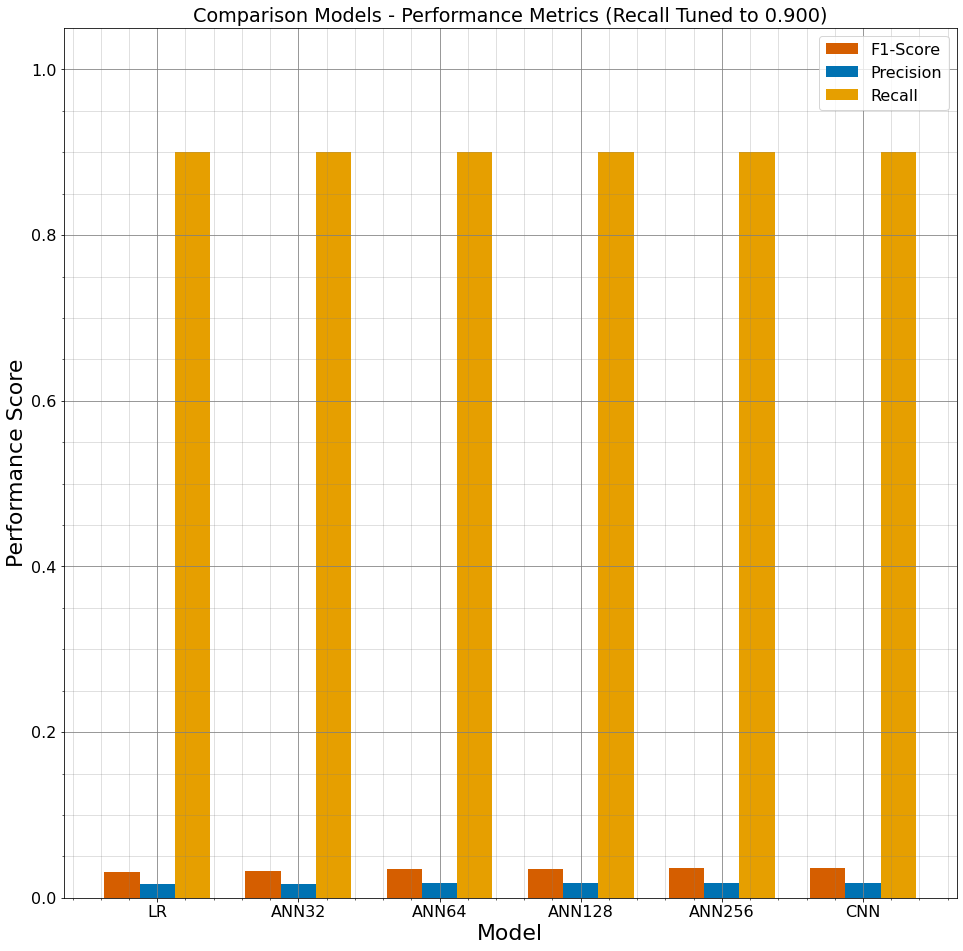

In [ ]:
accuracies = [LR_acc, ANN32_acc, ANN64_acc, ANN128_acc, ANN256_acc, CNN_acc]
f1s = [LR_f1, ANN32_f1, ANN64_f1, ANN128_f1, ANN256_f1, CNN_f1]
precisions = [LR_prec, ANN32_prec, ANN64_prec, ANN128_prec, ANN256_prec, CNN_prec]
recalls = [LR_rec, ANN32_rec, ANN64_rec, ANN128_rec, ANN256_rec, CNN_rec]

plt.rcParams["figure.figsize"] = (16,16)
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

#plt.bar(br1, accuracies, width=barWidth, label='Accuracy', color=color_p)
plt.rcParams.update({'font.size': 16})
plt.bar(br2, f1s, width=barWidth, label='F1-Score', color=color_red)
plt.bar(br3, precisions, width=barWidth, label='Precision', color=color_blue)
plt.bar(br4, recalls, width=barWidth, label='Recall', color=color_orange)
plt.ylim(0,1.05)

# Adding Xticks
plt.title("Comparison Models - Performance Metrics (Recall Tuned to 0.900)")
plt.xlabel('Model', fontsize = 22)
plt.ylabel('Performance Score', fontsize = 22)
plt.xticks([r + 2*barWidth for r in range(len(model_names))], model_names)
plt.minorticks_on()
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='-', alpha=0.3)
plt.legend()
plt.show()


In [ ]:
print("========== LR ==========")
print_performance_metrics(LR_acc, LR_f1, LR_prec, LR_rec, threshold=thr_LR_recall, print_threshold=True)
print("========== ANN32 ==========")
print_performance_metrics(ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec, threshold=thr_ANN32_recall, print_threshold=True)
print("========== ANN64 ==========")
print_performance_metrics(ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec, threshold=thr_ANN64_recall, print_threshold=True)
print("========== ANN128 ==========")
print_performance_metrics(ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec, threshold=thr_ANN128_recall, print_threshold=True)
print("========== ANN256 ==========")
print_performance_metrics(ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec, threshold=thr_ANN256_recall, print_threshold=True)
print("========== CNN ==========")
print_performance_metrics(CNN_acc, CNN_f1, CNN_prec, CNN_rec, threshold=thr_CNN_recall, print_threshold=True)


========== LR ==========
	Threshold: 0.064
	Accuracy: 0.455
	F1-Score: 0.032
	Precision: 0.016
	Recall: 0.900
========== ANN32 ==========
	Threshold: 0.005
	Accuracy: 0.471
	F1-Score: 0.033
	Precision: 0.017
	Recall: 0.900
========== ANN64 ==========
	Threshold: 0.060
	Accuracy: 0.503
	F1-Score: 0.035
	Precision: 0.018
	Recall: 0.900
========== ANN128 ==========
	Threshold: 0.001
	Accuracy: 0.498
	F1-Score: 0.034
	Precision: 0.017
	Recall: 0.900
========== ANN256 ==========
	Threshold: 0.050
	Accuracy: 0.516
	F1-Score: 0.035
	Precision: 0.018
	Recall: 0.900
========== CNN ==========
	Threshold: 0.098
	Accuracy: 0.517
	F1-Score: 0.036
	Precision: 0.018
	Recall: 0.900


In [ ]:
print_latex("Logistic Regression", LR_acc, LR_f1, LR_prec, LR_rec)
print_latex("Artificial Neural Network - 32 Neurons", ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec)
print_latex("Artificial Neural Network - 64 Neurons", ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec)
print_latex("Artificial Neural Network - 128 Neurons", ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec)
print_latex("Artificial Neural Network - 256 Neurons", ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec)
print_latex("Convolutional Neural Network", CNN_acc, CNN_f1, CNN_prec, CNN_rec)

Logistic Regression & 0.455 & 0.032 & 0.016 & 0.900 \\[10pt]
Artificial Neural Network - 32 Neurons & 0.471 & 0.033 & 0.017 & 0.900 \\[10pt]
Artificial Neural Network - 64 Neurons & 0.503 & 0.035 & 0.018 & 0.900 \\[10pt]
Artificial Neural Network - 128 Neurons & 0.498 & 0.034 & 0.017 & 0.900 \\[10pt]
Artificial Neural Network - 256 Neurons & 0.516 & 0.035 & 0.018 & 0.900 \\[10pt]
Convolutional Neural Network & 0.517 & 0.036 & 0.018 & 0.900 \\[10pt]


#### 50-50 split comparisons

In [ ]:
y_pred_LR5050 = LR.predict(X_comp_test5050)[:,1]
thr_LR_recall5050 = tune_recall_threshold(y_pred_LR5050, y_test5050, recall_min=0.90)

y_pred_ANN325050 = ANN32.predict(X_comp_test5050)[:,1]
thr_ANN32_recall5050 = tune_recall_threshold(y_pred_ANN325050, y_test5050, recall_min=0.90)

y_pred_ANN645050 = ANN64.predict(X_comp_test5050)[:,1]
thr_ANN64_recall5050 = tune_recall_threshold(y_pred_ANN645050, y_test5050, recall_min=0.90)

y_pred_ANN1285050 = ANN128.predict(X_comp_test5050)[:,1]
thr_ANN128_recall5050 = tune_recall_threshold(y_pred_ANN1285050, y_test5050, recall_min=0.90)

y_pred_ANN2565050 = ANN256.predict(X_comp_test5050)[:,1]
thr_ANN256_recall5050 = tune_recall_threshold(y_pred_ANN2565050, y_test5050, recall_min=0.90)

y_pred_CNN5050 = model.predict(X_test5050)[:,1]
thr_CNN_recall5050 = tune_recall_threshold(y_pred_CNN5050, y_test5050, recall_min=0.90)

In [ ]:
model_names = ['LR', 'ANN32', 'ANN64', 'ANN128', 'ANN256', 'CNN']

LR_acc, LR_f1, LR_prec, LR_rec = scores(y_test5050, y_pred_LR5050, threshold=0.5)
ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec = scores(y_test5050, y_pred_ANN325050, threshold=0.5)
ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec = scores(y_test5050, y_pred_ANN645050, threshold=0.5)
ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec = scores(y_test5050, y_pred_ANN1285050, threshold=0.5)
ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec = scores(y_test5050, y_pred_ANN2565050, threshold=0.5)
CNN_acc, CNN_f1, CNN_prec, CNN_rec = scores(y_test5050, y_pred_CNN5050, threshold=0.5)


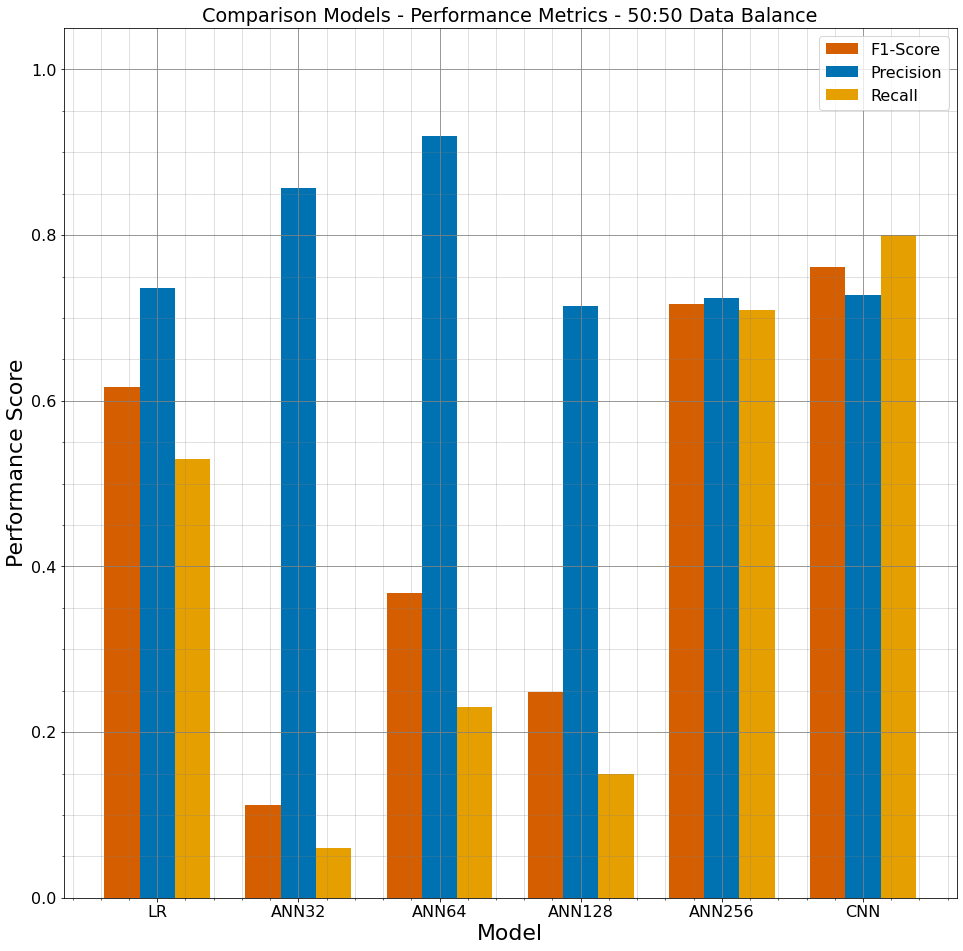

In [ ]:
accuracies = [LR_acc, ANN32_acc, ANN64_acc, ANN128_acc, ANN256_acc, CNN_acc]
f1s = [LR_f1, ANN32_f1, ANN64_f1, ANN128_f1, ANN256_f1, CNN_f1]
precisions = [LR_prec, ANN32_prec, ANN64_prec, ANN128_prec, ANN256_prec, CNN_prec]
recalls = [LR_rec, ANN32_rec, ANN64_rec, ANN128_rec, ANN256_rec, CNN_rec]

plt.rcParams["figure.figsize"] = (16,16)
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

#plt.bar(br1, accuracies, width=barWidth, label='Accuracy', color=color_p)
plt.rcParams.update({'font.size': 16})
plt.bar(br2, f1s, width=barWidth, label='F1-Score', color=color_red)
plt.bar(br3, precisions, width=barWidth, label='Precision', color=color_blue)
plt.bar(br4, recalls, width=barWidth, label='Recall', color=color_orange)
plt.ylim(0,1.05)

# Adding Xticks
plt.title("Comparison Models - Performance Metrics - 50:50 Data Balance")
plt.xlabel('Model', fontsize = 22)
plt.ylabel('Performance Score', fontsize = 22)
plt.xticks([r + 2*barWidth for r in range(len(model_names))], model_names)
plt.minorticks_on()
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='-', alpha=0.3)
plt.legend()
plt.show()


In [ ]:
print("========== LR ==========")
print_performance_metrics(LR_acc, LR_f1, LR_prec, LR_rec)
print("========== ANN32 ==========")
print_performance_metrics(ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec)
print("========== ANN64 ==========")
print_performance_metrics(ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec)
print("========== ANN128 ==========")
print_performance_metrics(ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec)
print("========== ANN256 ==========")
print_performance_metrics(ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec)
print("========== CNN ==========")
print_performance_metrics(CNN_acc, CNN_f1, CNN_prec, CNN_rec)


========== LR ==========
	Accuracy: 0.670
	F1-Score: 0.616
	Precision: 0.736
	Recall: 0.530
========== ANN32 ==========
	Accuracy: 0.525
	F1-Score: 0.112
	Precision: 0.857
	Recall: 0.060
========== ANN64 ==========
	Accuracy: 0.605
	F1-Score: 0.368
	Precision: 0.920
	Recall: 0.230
========== ANN128 ==========
	Accuracy: 0.545
	F1-Score: 0.248
	Precision: 0.714
	Recall: 0.150
========== ANN256 ==========
	Accuracy: 0.720
	F1-Score: 0.717
	Precision: 0.724
	Recall: 0.710
========== CNN ==========
	Accuracy: 0.750
	F1-Score: 0.762
	Precision: 0.727
	Recall: 0.800


In [ ]:
print_latex("Logistic Regression", LR_acc, LR_f1, LR_prec, LR_rec)
print_latex("Artificial Neural Network - 32 Neurons", ANN32_acc, ANN32_f1, ANN32_prec, ANN32_rec)
print_latex("Artificial Neural Network - 64 Neurons", ANN64_acc, ANN64_f1, ANN64_prec, ANN64_rec)
print_latex("Artificial Neural Network - 128 Neurons", ANN128_acc, ANN128_f1, ANN128_prec, ANN128_rec)
print_latex("Artificial Neural Network - 256 Neurons", ANN256_acc, ANN256_f1, ANN256_prec, ANN256_rec)
print_latex("Convolutional Neural Network", CNN_acc, CNN_f1, CNN_prec, CNN_rec)

Logistic Regression & 0.670 & 0.616 & 0.736 & 0.530 \\[10pt]
Artificial Neural Network - 32 Neurons & 0.525 & 0.112 & 0.857 & 0.060 \\[10pt]
Artificial Neural Network - 64 Neurons & 0.605 & 0.368 & 0.920 & 0.230 \\[10pt]
Artificial Neural Network - 128 Neurons & 0.545 & 0.248 & 0.714 & 0.150 \\[10pt]
Artificial Neural Network - 256 Neurons & 0.720 & 0.717 & 0.724 & 0.710 \\[10pt]
Convolutional Neural Network & 0.750 & 0.762 & 0.727 & 0.800 \\[10pt]


#### Accuracy

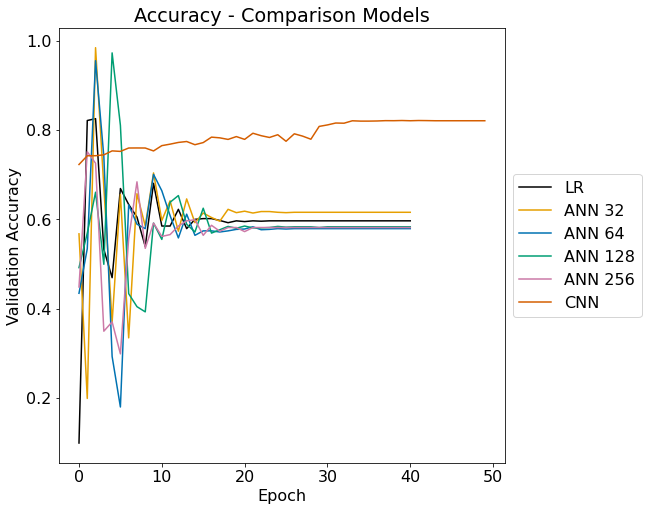

In [ ]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(history_LR['val_accuracy'], color=color_black, label='LR')
ax.plot(history_ANN32['val_accuracy'], color=color_orange, label='ANN 32')
ax.plot(history_ANN64['val_accuracy'], color=color_blue, label='ANN 64')
ax.plot(history_ANN128['val_accuracy'], color=color_bluish_green, label='ANN 128')
ax.plot(history_ANN256['val_accuracy'], color=color_pink, label='ANN 256')
ax.plot(history['val_accuracy'], color=color_red, label='CNN')
plt.title('Accuracy - Comparison Models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### ROC Curve

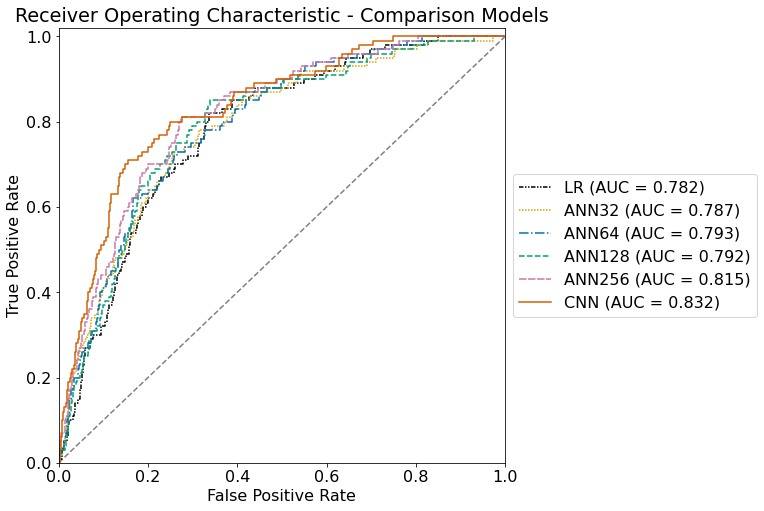

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Receiver Operating Characteristic - Comparison Models')
ax.plot([0, 1], [0, 1],'--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# LR
fpr, tpr, threshold = roc_curve(y_test, y_pred_LR)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'LR (AUC = %0.3f)' % roc_auc, color=color_black, linestyle=(0, (3, 1, 1, 1, 1, 1)))

# ANN32
fpr, tpr, threshold = roc_curve(y_test, y_pred_ANN32)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'ANN32 (AUC = %0.3f)' % roc_auc, color=color_orange, linestyle=(0,(1,1)))

# ANN64
fpr, tpr, threshold = roc_curve(y_test, y_pred_ANN64)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'ANN64 (AUC = %0.3f)' % roc_auc, color=color_blue, linestyle='dashdot')

# ANN128
fpr, tpr, threshold = roc_curve(y_test, y_pred_ANN128)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'ANN128 (AUC = %0.3f)' % roc_auc, color=color_bluish_green, linestyle='dashed')

# ANN256
fpr, tpr, threshold = roc_curve(y_test, y_pred_ANN256)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'ANN256 (AUC = %0.3f)' % roc_auc, color=color_pink, linestyle=(0,(5,1)))

# CNN
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = 'CNN (AUC = %0.3f)' % roc_auc, color=color_red, linestyle='solid')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Precision-Recall

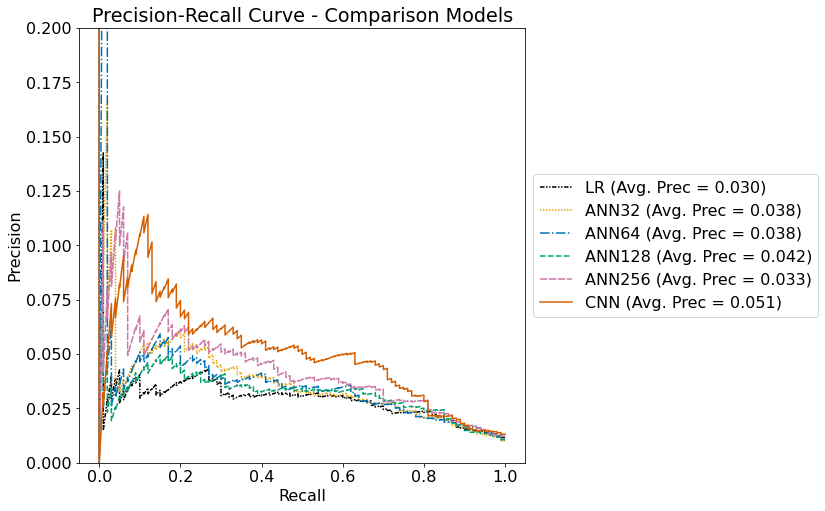

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Precision-Recall Curve - Comparison Models')
plt.xlabel('Recall')
plt.ylabel('Precision')

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LR)
ap = average_precision_score(y_test, y_pred_LR)
ax.plot(recall, precision, label = f'LR (Avg. Prec = {ap:0.3f})', color=color_black, linestyle=(0, (3, 1, 1, 1, 1, 1)))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ANN32)
ap = average_precision_score(y_test, y_pred_ANN32)
ax.plot(recall, precision, label = f'ANN32 (Avg. Prec = {ap:0.3f})', color=color_orange, linestyle=(0,(1,1)))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ANN64)
ap = average_precision_score(y_test, y_pred_ANN32)
ax.plot(recall, precision, label = f'ANN64 (Avg. Prec = {ap:0.3f})', color=color_blue, linestyle='dashdot')

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ANN128)
ap = average_precision_score(y_test, y_pred_ANN64)
ax.plot(recall, precision, label = f'ANN128 (Avg. Prec = {ap:0.3f})', color=color_bluish_green, linestyle='dashed')

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ANN256)
ap = average_precision_score(y_test, y_pred_ANN128)
ax.plot(recall, precision, label = f'ANN256 (Avg. Prec = {ap:0.3f})', color=color_pink, linestyle=(0,(5,1)))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN)
ap = average_precision_score(y_test, y_pred_CNN)
ax.plot(recall, precision, label = f'CNN (Avg. Prec = {ap:0.3f})', color=color_red, linestyle='solid')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.0,.2)
plt.show()

---

## Feature Analysis

### Feature Breakdown

There are 16 Features which can be roughly broken down in 5 groups
1. Land Surface Temperature (LST)
1. Vegetation (Fpar, Lai, Gpp, EVI)
1. Fire History (1yr, 5yr, 10yr)
1. Water Information (pr_wtr, precipitation)
1. Land Info (LC_Type[1-17], elevation)
1. Evapotranspiration (ET, LE, PET, PLE)

In [ ]:
# calculated dimension-index location of each layer after previous groups removal
# order dimension-indices descending to relative location when removing from X
group_evapo = [7,6,5,4]
group_land = [27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,6]
group_water = [6,5]
group_history = [7,6,5]
group_vegetation = [4,3,2,1]
group_lst = [0]

### Model Creation

In [ ]:
model_5 = gen_model(input_shape=(64,64,28)) # 5 = all-evapo
model_4 = gen_model(input_shape=(64,64,10)) # 4 = 5-land
model_3 = gen_model(input_shape=(64,64,8))  # 3 = 4-water
model_2 = gen_model(input_shape=(64,64,5))  # 2 = 3-history
model_1 = gen_model(input_shape=(64,64,1))  # 1 = 2-vegetation

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        8096      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)     

### Fitting

#### LST+Veg+Hist+Wtr+Land

In [ ]:
# Model - 5 groups
X_test_6 = X_test
toRemove = group_evapo
for r in toRemove:
  X = np.delete(X, r, 3)
  X_test = np.delete(X_test, r, 3)
X_test_5 = X_test

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/FeatureAnalysis/CNN_5_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_only_best=True
)

reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.15,
    patience=4, 
    min_lr=0,
    verbose=1
)

history_5 = model_5.fit(
    x=X, 
    y=y,
    epochs=50,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, reduceLR_callback])

model_5 = tf.keras.models.load_model(f'Models/FeatureAnalysis/CNN_5_Checkpoint/')

Epoch 1/50
1200/1200 [==============================] - ETA: 0s - loss: 1.9164 - accuracy: 0.7260
Epoch 1: saving model to Models/FeatureAnalysis/CNN_5_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_5_Checkpoint/assets
1200/1200 [==============================] - 17s 12ms/step - loss: 1.9164 - accuracy: 0.7260 - val_loss: 0.8009 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 2/50
1196/1200 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.7412
Epoch 2: saving model to Models/FeatureAnalysis/CNN_5_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_5_Checkpoint/assets
1200/1200 [==============================] - 13s 11ms/step - loss: 0.6448 - accuracy: 0.7410 - val_loss: 0.5360 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 3/50
1197/1200 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.7471
Epoch 3: saving model to Models/FeatureAnalysis/CNN_5_Checkpoint/
INFO:tensorflow:Assets written to: Models/Featur

In [ ]:
model_5.save('Models/FeatureAnalysis/Model5_v2.h5')
np.save('Models/FeatureAnalysis/Model5_history_v2.npy',history_5.history)

#### LST+Veg+Hist+Wtr

In [ ]:
# Model - 4 groups
toRemove = group_land
for r in toRemove:
  X = np.delete(X, r, 3)
  X_test = np.delete(X_test, r, 3)
X_test_4 = X_test

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/FeatureAnalysis/CNN_4_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_only_best=True
)

history_4 = model_4.fit(
    x=X, 
    y=y,
    epochs=50,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, reduceLR_callback])

model_4 = tf.keras.models.load_model(f'Models/FeatureAnalysis/CNN_4_Checkpoint/')

Epoch 1/50
1200/1200 [==============================] - ETA: 0s - loss: 1.5801 - accuracy: 0.7232
Epoch 1: saving model to Models/FeatureAnalysis/CNN_4_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_4_Checkpoint/assets
1200/1200 [==============================] - 14s 11ms/step - loss: 1.5801 - accuracy: 0.7232 - val_loss: 0.7215 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 2/50
1199/1200 [============================>.] - ETA: 0s - loss: 0.6196 - accuracy: 0.7386
Epoch 2: saving model to Models/FeatureAnalysis/CNN_4_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_4_Checkpoint/assets
1200/1200 [==============================] - 12s 10ms/step - loss: 0.6196 - accuracy: 0.7385 - val_loss: 0.5452 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 3/50
1196/1200 [============================>.] - ETA: 0s - loss: 0.5388 - accuracy: 0.7436
Epoch 3: saving model to Models/FeatureAnalysis/CNN_4_Checkpoint/
INFO:tensorflow:Assets written to: Models/Featur

In [ ]:
model_4.save('Models/FeatureAnalysis/Model4_v2.h5')
np.save('Models/FeatureAnalysis/Model4_history_v2.npy',history_4.history)

#### LST+Veg+Hist

In [ ]:
# Model - 3 groups
toRemove = group_water
for r in toRemove:
  X = np.delete(X, r, 3)
  X_test = np.delete(X_test, r, 3)
X_test_3 = X_test

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/FeatureAnalysis/CNN_3_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_only_best=True
)
history_3 = model_3.fit(
    x=X, 
    y=y,
    epochs=50,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, reduceLR_callback])

model_3 = tf.keras.models.load_model(f'Models/FeatureAnalysis/CNN_3_Checkpoint/')

Epoch 1/50
1197/1200 [============================>.] - ETA: 0s - loss: 1.8946 - accuracy: 0.7198
Epoch 1: saving model to Models/FeatureAnalysis/CNN_3_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_3_Checkpoint/assets
1200/1200 [==============================] - 13s 10ms/step - loss: 1.8920 - accuracy: 0.7198 - val_loss: 0.8274 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 2/50
1196/1200 [============================>.] - ETA: 0s - loss: 0.6410 - accuracy: 0.7360
Epoch 2: saving model to Models/FeatureAnalysis/CNN_3_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_3_Checkpoint/assets
1200/1200 [==============================] - 11s 10ms/step - loss: 0.6408 - accuracy: 0.7360 - val_loss: 0.5876 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 3/50
1198/1200 [============================>.] - ETA: 0s - loss: 0.5484 - accuracy: 0.7413
Epoch 3: saving model to Models/FeatureAnalysis/CNN_3_Checkpoint/
INFO:tensorflow:Assets written to: Models/Featur

In [ ]:
model_3.save('Models/FeatureAnalysis/Model3_v2.h5')
np.save('Models/FeatureAnalysis/Model3_history_v2.npy',history_3.history)

#### LST+Veg

In [ ]:
# Model - 2 groups
toRemove = group_history
for r in toRemove:
  X = np.delete(X, r, 3)
  X_test = np.delete(X_test, r, 3)
X_test_2 = X_test

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/FeatureAnalysis/CNN_2_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_only_best=True
)
history_2 = model_2.fit(
    x=X, 
    y=y,
    epochs=50,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, reduceLR_callback])

model_2 = tf.keras.models.load_model(f'Models/FeatureAnalysis/CNN_2_Checkpoint/')

Epoch 1/50
1200/1200 [==============================] - ETA: 0s - loss: 2.1529 - accuracy: 0.7153
Epoch 1: saving model to Models/FeatureAnalysis/CNN_2_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_2_Checkpoint/assets
1200/1200 [==============================] - 11s 9ms/step - loss: 2.1529 - accuracy: 0.7153 - val_loss: 0.9330 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 2/50
1200/1200 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.7306
Epoch 2: saving model to Models/FeatureAnalysis/CNN_2_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_2_Checkpoint/assets
1200/1200 [==============================] - 10s 9ms/step - loss: 0.7187 - accuracy: 0.7306 - val_loss: 0.5934 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 3/50
1199/1200 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.7324
Epoch 3: saving model to Models/FeatureAnalysis/CNN_2_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureA

In [ ]:
model_2.save('Models/FeatureAnalysis/Model2_v2.h5')
np.save('Models/FeatureAnalysis/Model2_history_v2.npy',history_2.history)

#### LST

In [ ]:
# Model - 1 groups
toRemove = group_vegetation
for r in toRemove:
  X = np.delete(X, r, 3)
  X_test = np.delete(X_test, r, 3)
X_test_1 = X_test

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Models/FeatureAnalysis/CNN_1_Checkpoint/',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_only_best=True
)

history_1 = model_1.fit(
    x=X, 
    y=y,
    epochs=50,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, reduceLR_callback])

model_1 = tf.keras.models.load_model(f'Models/FeatureAnalysis/CNN_1_Checkpoint/')

Epoch 1/50
1193/1200 [============================>.] - ETA: 0s - loss: 1.2157 - accuracy: 0.4994
Epoch 1: saving model to Models/FeatureAnalysis/CNN_1_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_1_Checkpoint/assets
1200/1200 [==============================] - 11s 8ms/step - loss: 1.2127 - accuracy: 0.4994 - val_loss: 0.7062 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 2/50
1200/1200 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5027
Epoch 2: saving model to Models/FeatureAnalysis/CNN_1_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureAnalysis/CNN_1_Checkpoint/assets
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6965 - accuracy: 0.5027 - val_loss: 0.6934 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 3/50
1199/1200 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009
Epoch 3: saving model to Models/FeatureAnalysis/CNN_1_Checkpoint/
INFO:tensorflow:Assets written to: Models/FeatureA

In [ ]:
model_1.save('Models/FeatureAnalysis/Model1_v2.h5')
np.save('Models/FeatureAnalysis/Model1_history_v2.npy',history_1.history)

### Load Models + History

In [ ]:
model_6 = tf.keras.models.load_model('Models/CNN/CNN_v2.h5')
history_6=np.load('Models/CNN/CNN_v2_history.npy',allow_pickle='TRUE').item()

model_5 = tf.keras.models.load_model('Models/FeatureAnalysis/Model5_v2.h5')
history_5=np.load('Models/FeatureAnalysis/Model5_history_v2.npy',allow_pickle='TRUE').item()

model_4 = tf.keras.models.load_model('Models/FeatureAnalysis/Model4.h5')
history_4=np.load('Models/FeatureAnalysis/Model4_history_v2.npy',allow_pickle='TRUE').item()

model_3 = tf.keras.models.load_model('Models/FeatureAnalysis/Model3.h5')
history_3=np.load('Models/FeatureAnalysis/Model3_history_v2.npy',allow_pickle='TRUE').item()

model_2 = tf.keras.models.load_model('Models/FeatureAnalysis/Model2.h5')
history_2=np.load('Models/FeatureAnalysis/Model2_history_v2.npy',allow_pickle='TRUE').item()

model_1_old = tf.keras.models.load_model('Models/FeatureAnalysis/Model1.h5')
history_1=np.load('Models/FeatureAnalysis/Model1_history_v2.npy',allow_pickle='TRUE').item()

### Evaluation

#### Accuracy

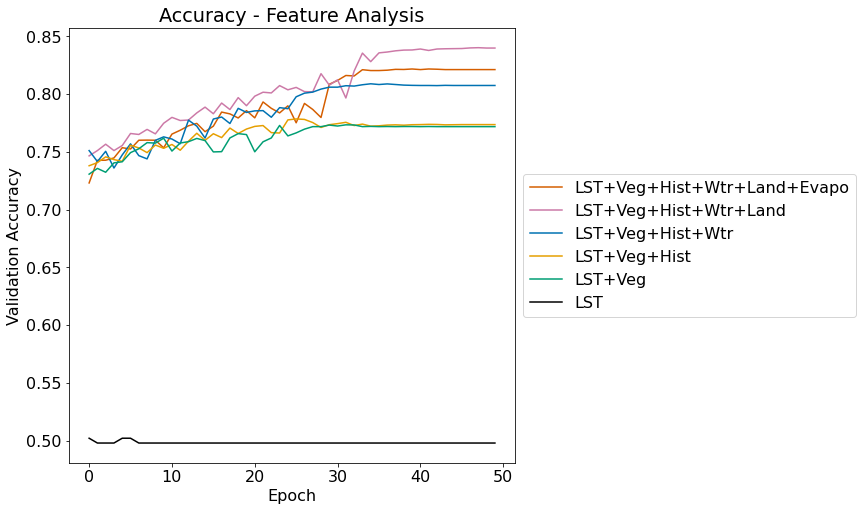

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Accuracy - Feature Analysis')
plt.xlabel('Recall')
plt.ylabel('Precision')

ax.plot(history_6['val_accuracy'], color=color_red, label='LST+Veg+Hist+Wtr+Land+Evapo')
ax.plot(history_5['val_accuracy'], color=color_pink, label='LST+Veg+Hist+Wtr+Land')
ax.plot(history_4['val_accuracy'], color=color_blue, label='LST+Veg+Hist+Wtr')
ax.plot(history_3['val_accuracy'], color=color_orange, label='LST+Veg+Hist')
ax.plot(history_2['val_accuracy'], color=color_bluish_green, label='LST+Veg')
ax.plot(history_1['val_accuracy'], color=color_black, label='LST')

plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
y_pred_CNN6 = model_6.predict(X_test_6)[:,1]

y_pred_CNN5 = model_5.predict(X_test_5)[:,1]

y_pred_CNN4 = model_4.predict(X_test_4)[:,1]

y_pred_CNN3 = model_3.predict(X_test_3)[:,1]

y_pred_CNN2 = model_2.predict(X_test_2)[:,1]

y_pred_CNN1 = model_1.predict(X_test_1)[:,1]

#### Base Model Comparisons

In [ ]:
model_names = ['LST+Veg+Hist+\nWtr+Land+Evapo', 'LST+Veg+Hist+\nWtr+Land', 'LST+Veg+Hist+\nWtr', 'LST+Veg+Hist', 'LST+Veg', 'LST']

acc_6, f1_6, prec_6, rec_6 = scores(y_test, y_pred_CNN6, threshold=0.5)
acc_5, f1_5, prec_5, rec_5 = scores(y_test, y_pred_CNN5, threshold=0.5)
acc_4, f1_4, prec_4, rec_4 = scores(y_test, y_pred_CNN4, threshold=0.5)
acc_3, f1_3, prec_3, rec_3 = scores(y_test, y_pred_CNN3, threshold=0.5)
acc_2, f1_2, prec_2, rec_2 = scores(y_test, y_pred_CNN2, threshold=0.5)
acc_1, f1_1, prec_1, rec_1 = scores(y_test, y_pred_CNN1, threshold=0.5)



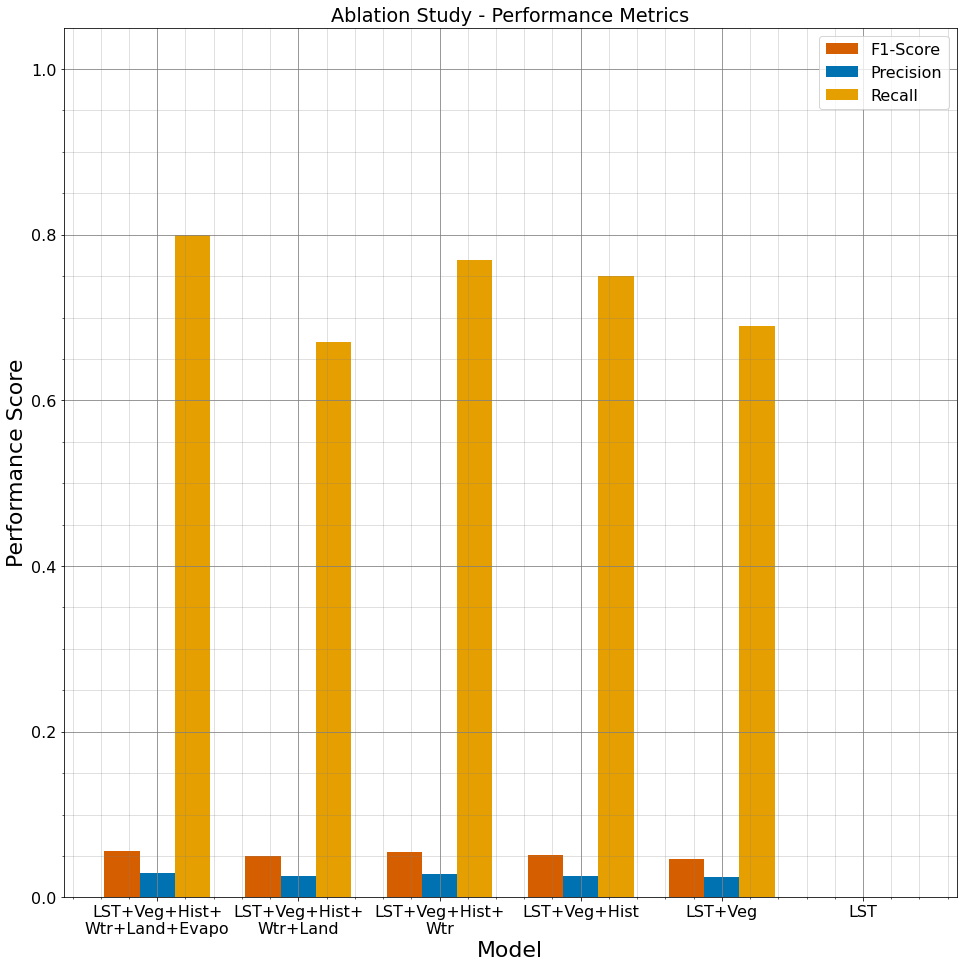

In [ ]:
accuracies = [acc_6, acc_5, acc_4, acc_3, acc_2, acc_1]
f1s = [f1_6, f1_5, f1_4, f1_3, f1_2, f1_1]
precisions = [prec_6, prec_5, prec_4, prec_3, prec_2, prec_1]
recalls = [rec_6, rec_5, rec_4, rec_3, rec_2, rec_1]

plt.rcParams["figure.figsize"] = (16,16)
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(model_names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

#plt.bar(br1, accuracies, width=barWidth, label='Accuracy', color=color_p)
plt.rcParams.update({'font.size': 16})
plt.bar(br2, f1s, width=barWidth, label='F1-Score', color=color_red)
plt.bar(br3, precisions, width=barWidth, label='Precision', color=color_blue)
plt.bar(br4, recalls, width=barWidth, label='Recall', color=color_orange)
plt.ylim(0,1.05)

# Adding Xticks
plt.title("Ablation Study - Performance Metrics")
plt.xlabel('Model', fontsize = 22)
plt.ylabel('Performance Score', fontsize = 22)
plt.xticks([r + 2*barWidth for r in range(len(model_names))], model_names)
plt.minorticks_on()
plt.grid(b=True, which='major', color='gray', linestyle='-')
plt.grid(b=True, which='minor', color='gray', linestyle='-', alpha=0.3)
plt.legend()
plt.show()


#### ROC Curve

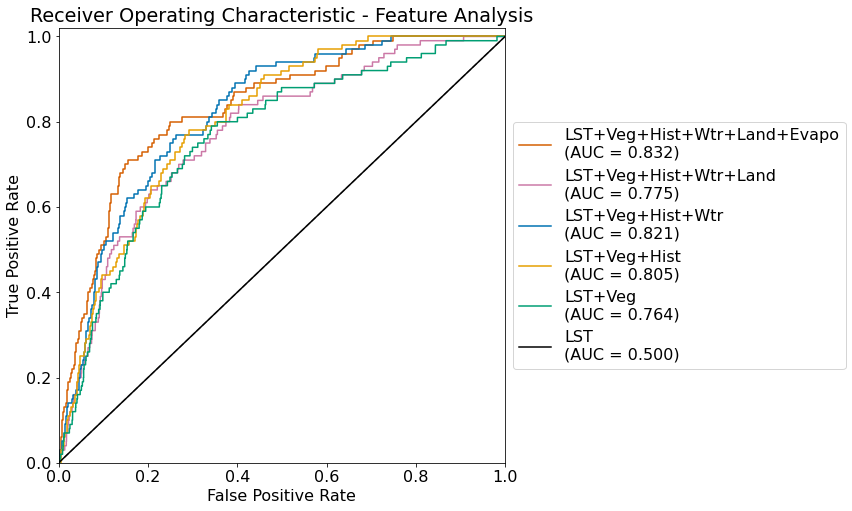

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Receiver Operating Characteristic - Feature Analysis')
ax.plot([0, 1], [0, 1],'--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# CNN6
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN6)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST+Veg+Hist+Wtr+Land+Evapo\n(AUC = {roc_auc:0.3f})', color=color_red)

# CNN5
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN5)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST+Veg+Hist+Wtr+Land\n(AUC = {roc_auc:0.3f})', color=color_pink)

# CNN4
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN4)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST+Veg+Hist+Wtr\n(AUC = {roc_auc:0.3f})', color=color_blue)

# CNN3
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN3)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST+Veg+Hist\n(AUC = {roc_auc:0.3f})', color=color_orange)

# CNN2
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN2)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST+Veg\n(AUC = {roc_auc:0.3f})', color=color_bluish_green)

# CNN1
fpr, tpr, threshold = roc_curve(y_test, y_pred_CNN1)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label = f'LST\n(AUC = {roc_auc:0.3f})', color=color_black)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Precision-Recall

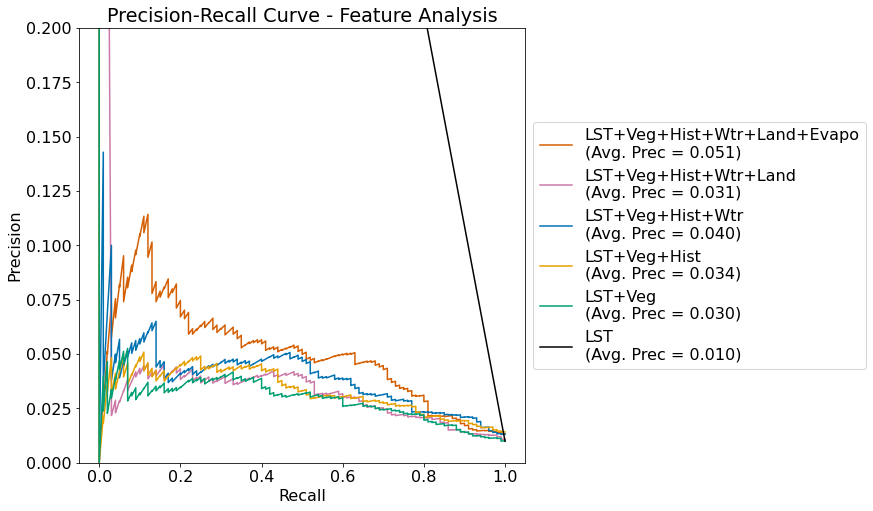

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Precision-Recall Curve - Feature Analysis')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0,0.2)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN6)
ap = average_precision_score(y_test, y_pred_CNN6)
ax.plot(recall, precision, label = f'LST+Veg+Hist+Wtr+Land+Evapo\n(Avg. Prec = {ap:0.3f})', color=color_red)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN5)
ap = average_precision_score(y_test, y_pred_CNN5)
ax.plot(recall, precision, label = f'LST+Veg+Hist+Wtr+Land\n(Avg. Prec = {ap:0.3f})', color=color_pink)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN4)
ap = average_precision_score(y_test, y_pred_CNN4)
ax.plot(recall, precision, label = f'LST+Veg+Hist+Wtr\n(Avg. Prec = {ap:0.3f})', color=color_blue)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN3)
ap = average_precision_score(y_test, y_pred_CNN3)
ax.plot(recall, precision, label = f'LST+Veg+Hist\n(Avg. Prec = {ap:0.3f})', color=color_orange)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN2)
ap = average_precision_score(y_test, y_pred_CNN2)
ax.plot(recall, precision, label = f'LST+Veg\n(Avg. Prec = {ap:0.3f})', color=color_bluish_green)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_CNN1)
ap = average_precision_score(y_test, y_pred_CNN1)
ax.plot(recall, precision, label = f'LST\n(Avg. Prec = {ap:0.3f})', color=color_black)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
print("========== CNN6 ==========")
print_performance_metrics(acc_6, f1_6, prec_6, rec_6)

print("========== CNN5 ==========")
print_performance_metrics(acc_5, f1_5, prec_5, rec_5)

print("========== CNN4 ==========")
print_performance_metrics(acc_4, f1_4, prec_4, rec_4)

print("========== CNN3 ==========")
print_performance_metrics(acc_3, f1_3, prec_3, rec_3)

print("========== CNN2 ==========")
print_performance_metrics(acc_2, f1_2, prec_2, rec_2)

print("========== CNN1 ==========")
print_performance_metrics(acc_1, f1_1, prec_1, rec_1)



========== CNN6 ==========
	Accuracy: 0.734
	F1-Score: 0.056
	Precision: 0.029
	Recall: 0.800
========== CNN5 ==========
	Accuracy: 0.747
	F1-Score: 0.050
	Precision: 0.026
	Recall: 0.670
========== CNN4 ==========
	Accuracy: 0.736
	F1-Score: 0.055
	Precision: 0.028
	Recall: 0.770
========== CNN3 ==========
	Accuracy: 0.722
	F1-Score: 0.051
	Precision: 0.026
	Recall: 0.750
========== CNN2 ==========
	Accuracy: 0.723
	F1-Score: 0.047
	Precision: 0.024
	Recall: 0.690
========== CNN1 ==========
	Accuracy: 0.990
	F1-Score: 0.000
	Precision: 0.000
	Recall: 0.000


In [ ]:
print_latex("LST+Veg+Hist+ Wtr+Land+Evapo", acc_6, f1_6, prec_6, rec_6)
print_latex("LST+Veg+Hist+ Wtr+Land", acc_5, f1_5, prec_5, rec_5)
print_latex("LST+Veg+Hist+ Wtr", acc_4, f1_4, prec_4, rec_4)
print_latex("LST+Veg+Hist", acc_3, f1_3, prec_3, rec_3)
print_latex("LST+Veg", acc_2, f1_2, prec_2, rec_2)
print_latex("LST", acc_1, f1_1, prec_1, rec_1)

LST+Veg+Hist+ Wtr+Land+Evapo & 0.734 & 0.056 & 0.029 & 0.800 \\[10pt]
LST+Veg+Hist+ Wtr+Land & 0.747 & 0.050 & 0.026 & 0.670 \\[10pt]
LST+Veg+Hist+ Wtr & 0.736 & 0.055 & 0.028 & 0.770 \\[10pt]
LST+Veg+Hist & 0.722 & 0.051 & 0.026 & 0.750 \\[10pt]
LST+Veg & 0.723 & 0.047 & 0.024 & 0.690 \\[10pt]
LST & 0.990 & 0.000 & 0.000 & 0.000 \\[10pt]
